In [1]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from tqdm import tqdm
import numpy as np

In [2]:
# Simple UNet for small images (28x28)
class SmallUNet(nn.Module):
  def __init__(self, in_channels=2, out_channels=1, base_channels=16):  # Changed to 2 input channels
    super().__init__()
    self.enc1 = nn.Sequential(nn.Conv2d(in_channels, base_channels, 3, padding=1), nn.ReLU())
    self.enc2 = nn.Sequential(nn.Conv2d(base_channels, base_channels*2, 3, padding=1), nn.ReLU())
    self.enc3 = nn.Sequential(nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1), nn.ReLU())

    self.dec3 = nn.Sequential(nn.Conv2d(base_channels*2, base_channels*2, 3, padding=1), nn.ReLU())
    self.dec2 = nn.Sequential(nn.Conv2d(base_channels*2, base_channels, 3, padding=1), nn.ReLU())
    self.dec1 = nn.Sequential(nn.Conv2d(base_channels, out_channels, 3, padding=1), nn.ReLU())

    self.pool = nn.MaxPool2d(2)
    self.up = nn.Upsample(scale_factor=2, mode='nearest')
    
    # timestep embedding
    self.time_mlp = nn.Sequential(
        nn.Linear(1, base_channels*2),
        nn.ReLU(),
        nn.Linear(base_channels*2, base_channels*2)
    )

  def forward(self, x, t):
    # t: [B] timesteps, scale to embedding
    t = t[:, None].float() / 1000  # simple scaling
    t_emb = self.time_mlp(t)[:, :, None, None]  # [B, hidden*2,1,1]
    
    # Encoder
    e1 = F.relu(self.enc1(x))
    e2 = F.relu(self.enc2(self.pool(e1)))
    e3 = F.relu(self.enc3(self.pool(e2)) + t_emb)
    
    # Decoder
    d3 = F.relu(self.dec3(self.up(e3)))
    d2 = F.relu(self.dec2(self.up(d3 + e2)))
    out = self.dec1(d2 + e1)
    return out

In [3]:
# Prompt embedding: map digit to string or word
digit_to_string = {i: str(i) for i in range(10)}
digit_to_word = {0: "zero", 1: "one", 2: "two", 3: "three", 4: "four", 5: "five", 6: "six", 7: "seven", 8: "eight", 9: "nine"}

# Simple prompt encoder (embedding layer)
class PromptEncoder(nn.Module):
  def __init__(self, vocab, emb_dim=8):
    super().__init__()
    self.vocab = vocab
    self.emb = nn.Embedding(len(vocab), emb_dim)

  def forward(self, labels):
    # labels is a list of strings (e.g., ["zero", "one", "two"])
    idxs = torch.tensor([self.vocab[label] for label in labels])
    idxs = idxs.to(next(self.parameters()).device)  # Move to same device as model
    return self.emb(idxs)

In [4]:
# Prepare MNIST
transform = transforms.Compose([transforms.ToTensor()])
mnist_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_loader = DataLoader(mnist_train, batch_size=64, shuffle=True)

In [5]:
# Build vocab for prompt encoder
use_words = True  # Set False to use strings "1", "2", ...
if use_words:
  vocab_list = [digit_to_word[i] for i in range(10)]
else:
  vocab_list = [digit_to_string[i] for i in range(10)]
vocab = {v: i for i, v in enumerate(vocab_list)}

In [6]:
# -------------------------
# 3️⃣ Diffusion utils
# -------------------------
T = 100  # number of diffusion steps
beta = np.linspace(1e-4, 0.02, T)
alpha = 1.0 - beta
alpha_bar = np.cumprod(alpha)

def q_sample(x0, t, noise=None):
    """Sample from q(x_t | x_0) - the forward diffusion process"""
    if noise is None:
        noise = torch.randn_like(x0)
    
    # Convert t to cpu for numpy indexing, then back to device
    t_cpu = t.cpu()
    a_bar = torch.tensor(alpha_bar[t_cpu], device=x0.device, dtype=x0.dtype)
    
    # Reshape for broadcasting
    while len(a_bar.shape) < len(x0.shape):
        a_bar = a_bar.unsqueeze(-1)
    
    return a_bar.sqrt() * x0 + (1 - a_bar).sqrt() * noise

In [7]:
# Model, optimizer, loss
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet = SmallUNet(in_channels=2).to(device)  # Specify 2 input channels
prompt_encoder = PromptEncoder(vocab, emb_dim=8).to(device)
optimizer = optim.Adam(list(unet.parameters()) + list(prompt_encoder.parameters()), lr=1e-3)
loss_fn = nn.MSELoss()

In [13]:
# Training loop - Diffusion model training
# The model learns to predict the noise that was added to create noisy images
for epoch in range(100):
    for imgs, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}"):
        
        # Move data to device
        imgs = imgs.to(device)
        
        # Get prompt embeddings
        prompts = [digit_to_word[l.item()] if use_words else digit_to_string[l.item()] for l in labels]
        prompt_emb = prompt_encoder(prompts)
        
        # Sample random timesteps for each image in the batch
        t = torch.randint(0, T, (imgs.size(0),), device=device)
        
        # Sample noise to add to the images
        noise = torch.randn_like(imgs)
        
        # Create noisy images at timestep t using the forward diffusion process
        x_t = q_sample(imgs, t, noise=noise)
        
        # Add prompt embedding as extra channel to the noisy image
        prompt_emb_expanded = prompt_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        input_imgs = torch.cat([x_t, prompt_emb_expanded[:,0:1]], dim=1)  # [B, 2, 28, 28]
        
        # Forward pass: model predicts the noise that was added
        predicted_noise = unet(input_imgs, t)
        
        # Loss: compare predicted noise with actual noise
        loss = loss_fn(predicted_noise, noise)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

Epoch 1: 100%|██████████| 938/938 [00:09<00:00, 100.78it/s]


Epoch 1 Loss: 0.5499


Epoch 2: 100%|██████████| 938/938 [00:09<00:00, 96.61it/s] 


Epoch 2 Loss: 0.5386


Epoch 3: 100%|██████████| 938/938 [00:10<00:00, 90.41it/s]


Epoch 3 Loss: 0.5297


Epoch 4: 100%|██████████| 938/938 [00:11<00:00, 84.66it/s]


Epoch 4 Loss: 0.5448


Epoch 5: 100%|██████████| 938/938 [00:09<00:00, 96.01it/s] 


Epoch 5 Loss: 0.5469


Epoch 6: 100%|██████████| 938/938 [00:09<00:00, 99.90it/s] 


Epoch 6 Loss: 0.5415


Epoch 7: 100%|██████████| 938/938 [00:09<00:00, 99.97it/s] 


Epoch 7 Loss: 0.5342


Epoch 8: 100%|██████████| 938/938 [00:09<00:00, 94.22it/s]


Epoch 8 Loss: 0.5298


Epoch 9: 100%|██████████| 938/938 [00:10<00:00, 90.39it/s] 


Epoch 9 Loss: 0.5537


Epoch 10: 100%|██████████| 938/938 [00:09<00:00, 95.25it/s] 


Epoch 10 Loss: 0.5351


Epoch 11: 100%|██████████| 938/938 [00:10<00:00, 89.21it/s] 


Epoch 11 Loss: 0.5472


Epoch 12: 100%|██████████| 938/938 [00:09<00:00, 96.01it/s] 


Epoch 12 Loss: 0.5425


Epoch 13: 100%|██████████| 938/938 [00:10<00:00, 93.30it/s]


Epoch 13 Loss: 0.5348


Epoch 14: 100%|██████████| 938/938 [00:09<00:00, 96.17it/s] 


Epoch 14 Loss: 0.5213


Epoch 15: 100%|██████████| 938/938 [00:10<00:00, 86.40it/s] 


Epoch 15 Loss: 0.5376


Epoch 16: 100%|██████████| 938/938 [00:10<00:00, 91.19it/s]


Epoch 16 Loss: 0.5241


Epoch 17: 100%|██████████| 938/938 [00:10<00:00, 92.07it/s]


Epoch 17 Loss: 0.5357


Epoch 18: 100%|██████████| 938/938 [00:10<00:00, 92.36it/s]


Epoch 18 Loss: 0.5293


Epoch 19: 100%|██████████| 938/938 [00:10<00:00, 93.22it/s] 


Epoch 19 Loss: 0.5389


Epoch 20: 100%|██████████| 938/938 [00:10<00:00, 90.49it/s]


Epoch 20 Loss: 0.5365


Epoch 21:  44%|████▍     | 415/938 [00:04<00:05, 93.43it/s]


KeyboardInterrupt: 

Ready to generate images. Run training first, then uncomment the generation code below.


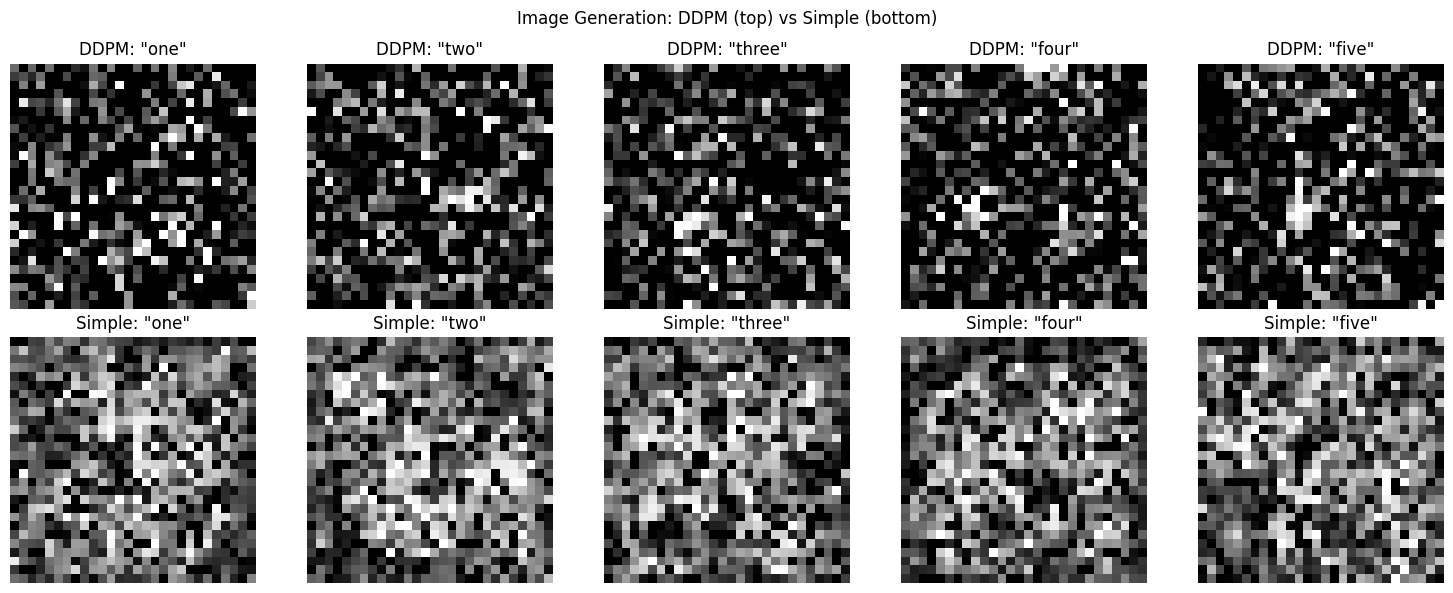

In [12]:
# Generate new image from text prompt - DDPM sampling
import matplotlib.pyplot as plt

def generate_image_ddpm(prompt_text, model, prompt_encoder, device, num_steps=50):
    """Generate image using DDPM reverse process"""
    model.eval()
    with torch.no_grad():
        # Start with pure noise
        img = torch.randn(1, 1, 28, 28).to(device)
        
        # Get prompt embedding
        prompt_emb = prompt_encoder([prompt_text])
        prompt_emb_expanded = prompt_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        
        # Reverse diffusion process
        timesteps = np.linspace(T-1, 0, num_steps).astype(int)
        
        for i, t_val in enumerate(timesteps):
            t = torch.tensor([t_val], device=device).long()
            
            # Combine current image with prompt embedding
            input_tensor = torch.cat([img, prompt_emb_expanded[:,0:1]], dim=1)
            
            # Predict noise
            predicted_noise = model(input_tensor, t)
            
            # Remove predicted noise (simplified DDPM step)
            alpha_t = alpha[t_val]
            alpha_bar_t = alpha_bar[t_val]
            
            if t_val > 0:
                # Not the final step - add some randomness
                beta_t = beta[t_val]
                noise = torch.randn_like(img)
                img = (1 / np.sqrt(alpha_t)) * (img - ((1 - alpha_t) / np.sqrt(1 - alpha_bar_t)) * predicted_noise)
                img = img + np.sqrt(beta_t) * noise
            else:
                # Final step - no noise
                img = (1 / np.sqrt(alpha_t)) * (img - ((1 - alpha_t) / np.sqrt(1 - alpha_bar_t)) * predicted_noise)
        
        # Clamp values
        img = torch.clamp(img, 0, 1)
        
        # Convert to numpy for display
        generated_img = img.cpu().squeeze().numpy()
        return generated_img

def generate_image_simple(prompt_text, model, prompt_encoder, device):
    """Simple single-step generation (for comparison)"""
    model.eval()
    with torch.no_grad():
        # Start with moderate noise
        img = torch.randn(1, 1, 28, 28).to(device) * 0.5 + 0.5
        
        # Get prompt embedding
        prompt_emb = prompt_encoder([prompt_text])
        prompt_emb_expanded = prompt_emb.unsqueeze(-1).unsqueeze(-1).expand(-1, -1, 28, 28)
        
        # Combine with prompt embedding
        input_tensor = torch.cat([img, prompt_emb_expanded[:,0:1]], dim=1)
        
        # Use a moderate timestep
        t = torch.tensor([T//2], device=device).long()
        
        # Predict noise and subtract it
        predicted_noise = model(input_tensor, t)
        generated = img - predicted_noise * 0.3  # Scale factor for single step
        generated = torch.clamp(generated, 0, 1)
        
        # Convert to numpy for display
        generated_img = generated.cpu().squeeze().numpy()
        return generated_img

# Test generation after training (uncomment after training completes)
# Generate and display images for different prompts
prompts_to_test = ["one", "two", "three", "four", "five"]

print("Ready to generate images. Run training first, then uncomment the generation code below.")

# Uncomment after training:

fig, axes = plt.subplots(2, len(prompts_to_test), figsize=(15, 6))
fig.suptitle('Image Generation: DDPM (top) vs Simple (bottom)')

for i, prompt in enumerate(prompts_to_test):
    # DDPM generation
    generated_img_ddpm = generate_image_ddpm(prompt, unet, prompt_encoder, device)
    axes[0, i].imshow(generated_img_ddpm, cmap='gray')
    axes[0, i].set_title(f'DDPM: "{prompt}"')
    axes[0, i].axis('off')
    
    # Simple generation
    generated_img_simple = generate_image_simple(prompt, unet, prompt_encoder, device)
    axes[1, i].imshow(generated_img_simple, cmap='gray')
    axes[1, i].set_title(f'Simple: "{prompt}"')
    axes[1, i].axis('off')

plt.tight_layout()
plt.show()
